### Subtomogram Alignment and Averaging

In [1]:
import numpy as np
import torch

In [2]:
ribosome = '/pscratch/sd/h/hnjones/denoise_et/ribosome'
cryocare = ribosome + '/cryocare'
xray = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome'
ddw = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ddw/refined_tomo_full.mrc'
!source ~/.bashrc
!export PYTHONPATH=$PYTHONPATH:/global/homes/h/hnjones/
!source $HOME/.bashrc
!source /global/homes/h/hnjones/.bashrc
!echo $PYTHONPATH
!echo $PATH

import os

cryocare_10k = cryocare + '/10_run/denoised_10k.rec/cryocare_prediction.mrc'
cryocare_50k = cryocare + '/50_run/denoised_50k.rec/cryocare_prediction.mrc'
ground_truth = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/noise_free/noisefree_full_rec.mrc'
volume = xray + '/TEM_simulator/volume.mrc'

import mrcfile
import torch, numpy as np
import matplotlib.pyplot as plt

/opt/nersc/pymon:/global/cfs/projectdirs/m4055/kpande:/global/homes/h/hnjones/
/global/common/software/nersc9/jupyter/ex/24-05/nersc-utils:/opt/nersc/pe/bin:/global/common/software/nersc/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/compute-sanitizer:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/libnvvp:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Compute:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Systems/bin:/opt/cray/pe/perftools/23.12.0/bin:/opt/cray/pe/papi/7.0.1.2/bin:/opt/cray/pe/craype/2.7.30/bin:/opt/cray/pe/mpich/8.1.28/ofi/gnu/12.3/bin:/opt/cray/pe/mpich/8.1.28/bin:/opt/cray/libfabric/1.15.2.0/bin:/usr/local/bin:/usr/bin:/bin:/usr/lib/mit/bin:/opt/cray/pe/bin


In [3]:
gtruth = torch.tensor(mrcfile.read(ground_truth))
cryocare_10 = torch.tensor(mrcfile.read(cryocare_10k))
cryocare_50 = torch.tensor(mrcfile.read(cryocare_50k))
ddw = torch.tensor(mrcfile.read(ddw))
volume = torch.tensor(mrcfile.read(volume))

In [4]:
print(gtruth.shape, cryocare_10.shape, cryocare_50.shape, ddw.shape, volume.shape)

torch.Size([2000, 200, 2000]) torch.Size([2000, 200, 2000]) torch.Size([200, 2000, 2000]) torch.Size([200, 2000, 2000]) torch.Size([200, 1000, 1000])


In [5]:
#coordinates are output centered in nm before magnification
coords = torch.Tensor(np.genfromtxt('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ribo_coordinates.txt', skip_header = 2))

61 pixel_radius
39 neighbor distance
picked 5 particles


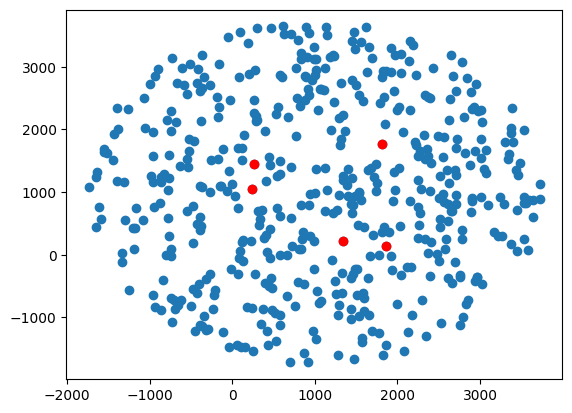

tensor(83.0920)


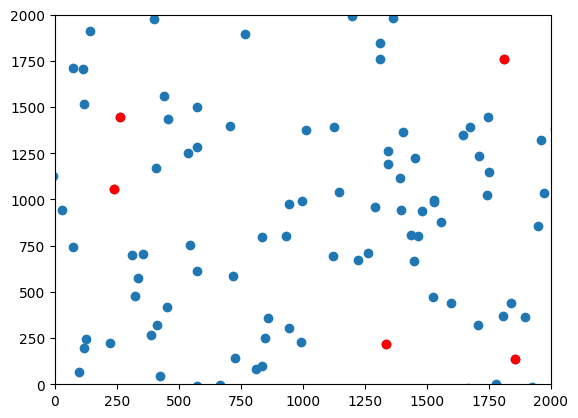

In [75]:
#80S ribosomes have diameters up to 300-320 A which is 30-32 nm
#We know our tem simulator uses magnification 
#750000 with detector size 16000 nm
magnification = 75000
detector_size_nm = 16000
ribosome_radius = 13 # nm
factor = magnification / detector_size_nm
ribosome_diameter = 2 * ribosome_radius
ribo_pixel_radius = int(torch.round(torch.Tensor([factor * ribosome_radius])))
ribo_pixel_diameter = 2 * ribo_pixel_radius
print(ribo_pixel_radius, 'pixel_radius')
print(ribosome_diameter + ribosome_radius, 'neighbor distance')
correct_size = torch.Size([200, 2000, 2000]) #z, y, x

#we only need to crop in the x and y planes



def check_transpose(in_tensor: torch.Tensor, correct_shape: torch.Size):
    if in_tensor.shape != correct_shape:
        return torch.transpose(in_tensor, 0, 1)
    return in_tensor

gtruth = check_transpose(gtruth, correct_size)

particle_file = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ribo_coordinates.txt'
coords = torch.Tensor(np.genfromtxt(particle_file, skip_header = 2))
orientations = coords[:, -3:]
coords = coords[:,:3]

def pick_particles(coords: torch.Tensor):
    coords = coords[((torch.abs(coords[:,0]) + ribosome_diameter) * factor <= correct_size[1]/2) & ((torch.abs(coords[:,1]) + ribosome_diameter) * factor <= correct_size[2]/2)]
    upper_distance_matrix = torch.triu(torch.cdist(coords, coords, p=2) > ribosome_diameter + ribosome_radius)
    final_mask = ((upper_distance_matrix + torch.transpose(upper_distance_matrix, 0, 1)).sum(dim = 0) == upper_distance_matrix.shape[0]-1)
    coords = coords[final_mask]
    return coords

picked_coords = pick_particles(coords)

print(f"picked {int(picked_coords.shape[0])} particles")
plt.scatter(coords[:,0] * factor + 1000, coords[:,1] * factor + 1000)
plt.scatter(picked_coords[:,0] * factor + 1000, picked_coords[:,1] * factor + 1000, c= 'r')
plt.show()
#print minimum distance of kept particles
print(torch.min(torch.cdist(picked_coords, picked_coords, p = 2)[torch.triu(torch.cdist(picked_coords, picked_coords, p = 2)> 0.0)]))
plt.scatter(coords[:,0] * factor + 1000, coords[:,1] * factor + 1000)
plt.scatter(picked_coords[:,0] * factor + 1000, picked_coords[:,1] * factor + 1000, c= 'r')
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.show()

In [153]:
import numpy as np
def extract_subtomos(volume: torch.Tensor, picked_coordinates: torch.Tensor):
    #tensor_of_subtomos = torch.empty((int(picked_coordinates.shape[0]), 2 * ribo_pixel_diameter, 2 * ribo_pixel_diameter, 2* ribo_pixel_radius), dtype = torch.float64)
    tensor_of_subtomos = np.empty(shape = int(picked_coordinates.shape[0]), dtype = object)
    print(tensor_of_subtomos.shape)
    print(volume.shape)
    for particle in range(int(picked_coordinates.shape[0])):
        pixel_coord = torch.round(torch.Tensor([picked_coordinates[particle,0] * factor + volume.shape[-1]/2,
                                                picked_coordinates[particle,1] * factor + volume.shape[-2]/2,
                                                volume.shape[-3] - (picked_coordinates[particle,2] * factor + volume.shape[-3]/2)])).int()
        print(pixel_coord, ribo_pixel_diameter)
        bounds = torch.Tensor([[pixel_coord[2] - ribo_pixel_radius, pixel_coord[2] + ribo_pixel_radius],
                                [pixel_coord[1] - ribo_pixel_diameter, pixel_coord[1] + ribo_pixel_diameter],
                                [pixel_coord[0] - ribo_pixel_diameter, pixel_coord[0] + ribo_pixel_diameter]]).int()
        bounds[(bounds < 0)] = 0
        bounds[0,1][bounds[0,1] > volume.shape[0]] = volume.shape[0]
        tensor_of_subtomos[particle] = volume[int(bounds[0,0]) : int(bounds[0,1]),
                                              int(bounds[1,0]) : int(bounds[1,1]),
                                              int(bounds[2,0]) : int(bounds[2,1])].numpy()
    return tensor_of_subtomos

out = extract_subtomos(gtruth, picked_coords)

(5,)
torch.Size([200, 2000, 2000])
tensor([1810, 1761,   54], dtype=torch.int32) 122
tensor([ 264, 1445,   88], dtype=torch.int32) 122
tensor([1336,  217,   90], dtype=torch.int32) 122
tensor([1855,  135,   44], dtype=torch.int32) 122
tensor([ 240, 1057,   59], dtype=torch.int32) 122


(115, 244, 244)


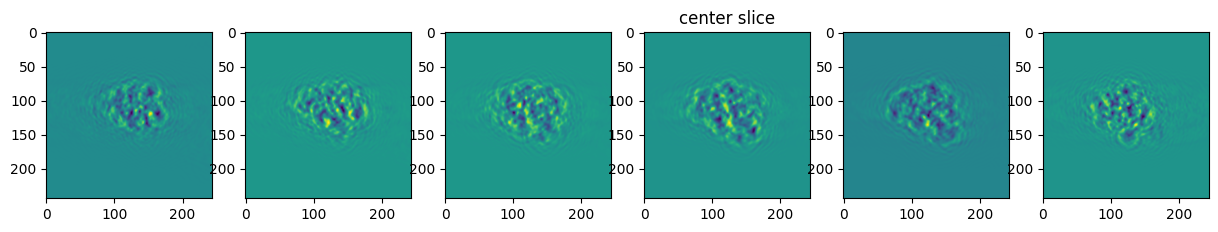

(122, 244, 244)


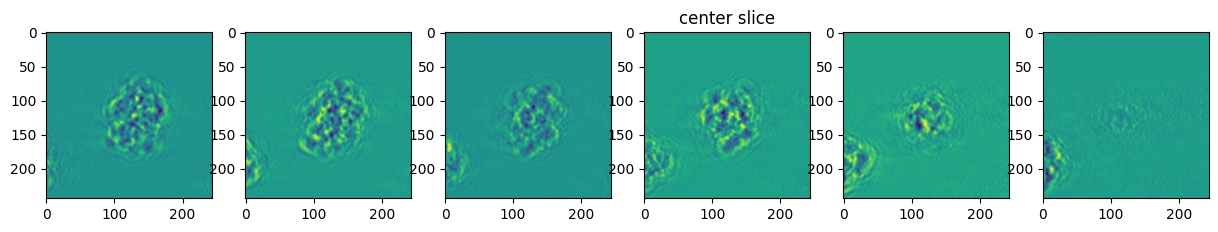

(122, 244, 244)


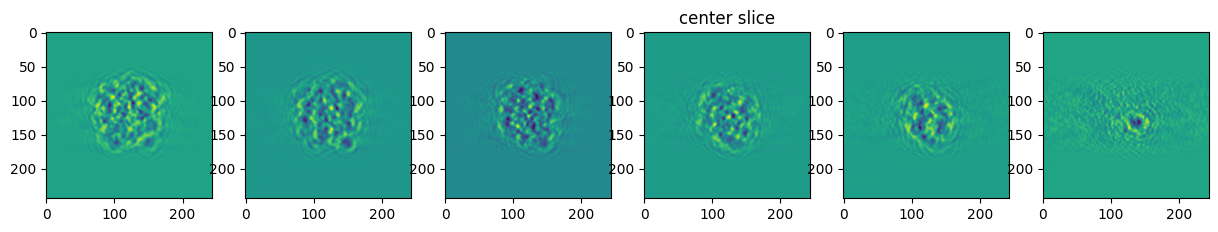

(105, 244, 244)


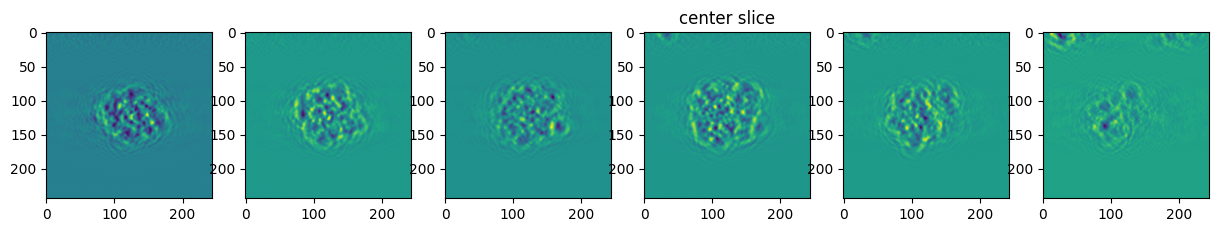

(120, 244, 244)


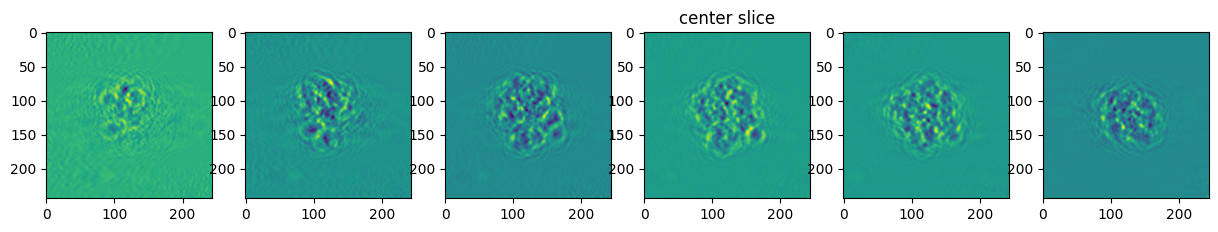

In [160]:
zslice = [54, 88, 90, 44, 59]
for index, subtomo in enumerate(out):
    print(subtomo.shape)
    fig, ax = plt.subplots(nrows = 1, ncols = 6)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].imshow(subtomo[zslice[index]-30,:,:])
    ax[1].imshow(subtomo[zslice[index]-20,:,:])
    ax[2].imshow(subtomo[zslice[index]-10,:,:])
    ax[3].imshow(subtomo[zslice[index],:,:])
    ax[3].set_title("center slice")
    ax[4].imshow(subtomo[zslice[index]+10,:,:])
    ax[5].imshow(subtomo[zslice[index]+30,:,:])
    plt.show()

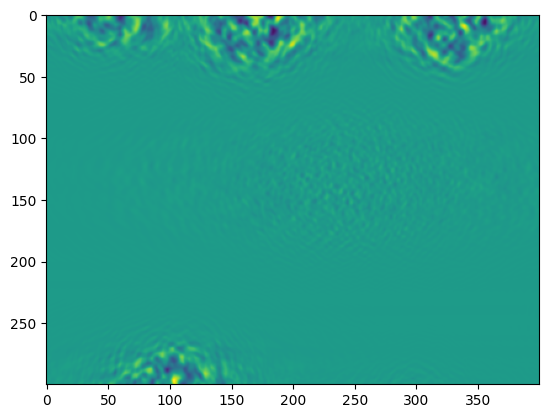

In [85]:
plt.imshow(gtruth[100,:300,1600:2000])

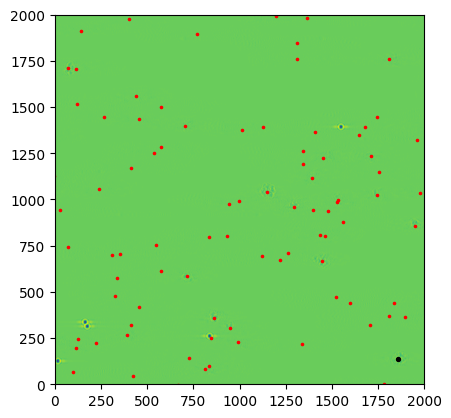

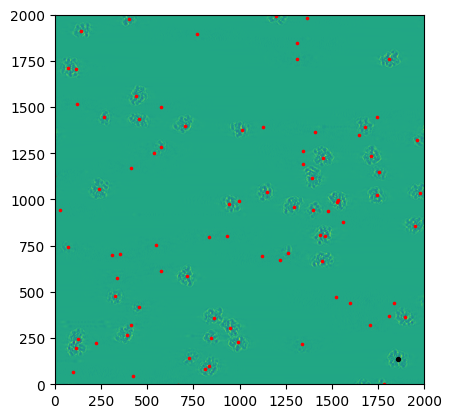

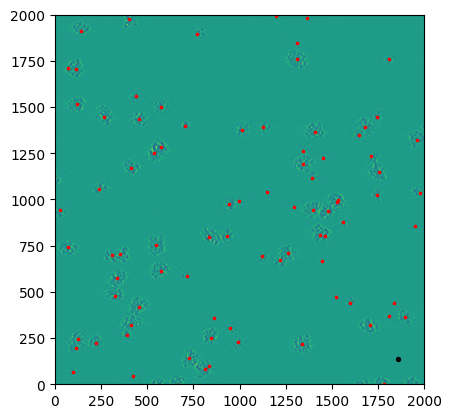

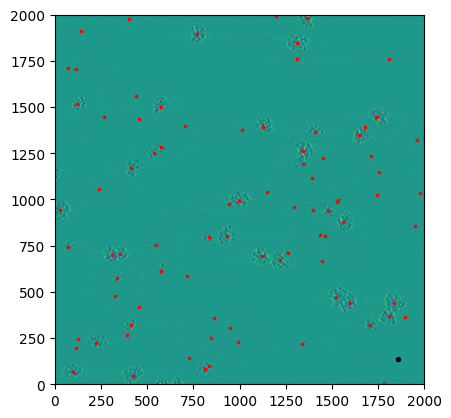

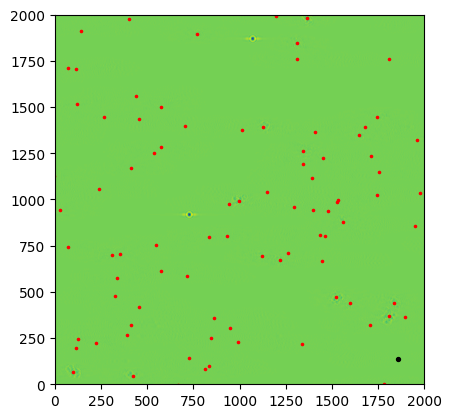

In [77]:
prob_slice = [0, 50, 100, 150, 199]
for this_slice in prob_slice:
    plt.imshow(gtruth[this_slice,:,:].numpy())
    plt.scatter((coords[:, 0] * 75/16) + 1000, (coords[:,1] * 75/16) + 1000, c = 'r', s = 2.5)
    plt.scatter(1855, 135, c = 'k', s = 8)
    plt.xlim(0, 2000)
    plt.ylim(0, 2000)
    plt.show()